In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)  # This makes your random data reproducible — same results every run
n = 50000           # Total number of simulated users

In [2]:
# Basic user demographics and account info
df = pd.DataFrame({
    'user_id': range(1, n + 1),
    
    # Randomly assign to control or treatment (50/50 split)
    'group': np.random.choice(['control', 'treatment'], n, p=[0.5, 0.5]),
    
    # Age distribution — skewed younger, like real Instagram
    'age_group': np.random.choice(
        ['18-24', '25-34', '35-44', '45+'], 
        n, 
        p=[0.38, 0.32, 0.18, 0.12]
    ),
    
    # Account type — most people are casual users
    'account_type': np.random.choice(
        ['casual', 'creator', 'business'], 
        n, 
        p=[0.65, 0.25, 0.10]
    ),
    
    # How long they've been on the platform (months)
    'account_age_months': np.random.randint(1, 84, n),
    
    # Number of people they follow
    'following_count': np.random.lognormal(mean=5.5, sigma=0.8, size=n).astype(int).clip(1, 5000),
    
    # Number of followers they have
    'follower_count': np.random.lognormal(mean=4.5, sigma=1.2, size=n).astype(int).clip(0, 100000),
})

print(df.head())
print(df.shape)

   user_id      group age_group account_type  account_age_months  \
0        1    control     35-44       casual                  83   
1        2  treatment     25-34       casual                  66   
2        3  treatment     18-24       casual                  72   
3        4  treatment     35-44       casual                  36   
4        5    control     25-34       casual                  58   

   following_count  follower_count  
0              785              35  
1              554             467  
2              108               7  
3              117               7  
4              303              56  
(50000, 7)


In [3]:
# Baseline behavior — what users were doing BEFORE the experiment started
# This is called "pre-experiment" data — important for A/B test validity checks

df['pre_daily_active_minutes'] = np.random.normal(25, 10, n).clip(1, 120).round(1)
df['pre_interaction_rate'] = np.random.beta(2, 8, n).round(4)  # Beta dist = naturally between 0 and 1
df['pre_stories_watched'] = np.random.poisson(lam=8, size=n)   # Poisson = count data
df['pre_scroll_depth'] = np.random.uniform(0.1, 1.0, n).round(2)

In [4]:
# Now add the POST-experiment behavior
# The treatment group (AI feed) gets a LIFT in engagement — this is the effect we're testing

# Start with base post-experiment behavior (similar to pre, with some natural drift)
df['daily_active_minutes'] = np.random.normal(26, 10, n).clip(1, 120).round(1)
df['interaction_rate'] = np.random.beta(2, 8, n).round(4)
df['stories_watched'] = np.random.poisson(lam=8, size=n)
df['scroll_depth'] = np.random.uniform(0.1, 1.0, n).round(2)

# Apply treatment effect — AI feed users engage ~12% more
# But the effect is STRONGER for 25-34 age group (this creates an interesting segmentation finding)
treatment_mask = df['group'] == 'treatment'
young_mask = df['age_group'] == '18-24'

df.loc[treatment_mask, 'daily_active_minutes'] *= 1.12
df.loc[treatment_mask & ~young_mask, 'daily_active_minutes'] *= 1.05  # Extra lift for older groups
df.loc[treatment_mask, 'interaction_rate'] *= 1.08
df.loc[treatment_mask, 'stories_watched'] = (df.loc[treatment_mask, 'stories_watched'] * 1.10).astype(int)

df['daily_active_minutes'] = df['daily_active_minutes'].round(1)

In [5]:
# Churn = user went inactive within 30 days after the experiment
# Churn probability depends on behavior — low engagement = higher churn risk

def calculate_churn_prob(row):
    base_prob = 0.12  # 12% baseline churn rate
    
    # Low engagement increases churn risk
    if row['daily_active_minutes'] < 15:
        base_prob += 0.15
    elif row['daily_active_minutes'] > 40:
        base_prob -= 0.05
    
    # Haven't interacted much = higher churn
    if row['interaction_rate'] < 0.05:
        base_prob += 0.10
    
    # Young casual users in AI feed showed more confusion/churn (interesting finding!)
    if row['age_group'] == '18-24' and row['account_type'] == 'casual' and row['group'] == 'treatment':
        base_prob += 0.08
    
    # Long-tenured users churn less
    if row['account_age_months'] > 36:
        base_prob -= 0.04
    
    return np.clip(base_prob, 0.01, 0.95)

df['churn_prob'] = df.apply(calculate_churn_prob, axis=1)
df['churned_30d'] = np.random.binomial(1, df['churn_prob'])
df['days_since_last_login'] = np.where(
    df['churned_30d'] == 1,
    np.random.randint(15, 45, n),   # Churned users haven't logged in recently
    np.random.randint(0, 10, n)     # Active users log in frequently
)

print(f"Overall churn rate: {df['churned_30d'].mean():.1%}")
print(f"Control churn rate: {df[df.group=='control']['churned_30d'].mean():.1%}")
print(f"Treatment churn rate: {df[df.group=='treatment']['churned_30d'].mean():.1%}")

Overall churn rate: 12.6%
Control churn rate: 12.2%
Treatment churn rate: 12.9%


In [6]:
# Generate realistic-feeling post captions
# We'll create a pool of captions and assign them to users

caption_templates = [
    # Lifestyle
    "Morning coffee and good vibes only ☕ #morningroutine #lifestyle",
    "Sunday reset mode activated 🌿 #selfcare #wellness",
    "Chasing sunsets and good energy 🌅 #goldenhour #vibes",
    # Food
    "Made this from scratch and honestly obsessed 🍳 #homecooking #foodie",
    "This place just became my new favorite spot 🍜 #foodblogger #eats",
    # Sustainability
    "Small swaps, big impact 🌱 Switched to reusable everything #sustainability #ecofriendly",
    "Thrifted this entire outfit for under $20 ♻️ #thrifting #sustainablefashion",
    # Learning / Micro-tutorials
    "3 things I wish I knew before starting my career 📌 #careeradvice #growthmindset",
    "How I learned Python in 30 days 💻 #coding #selflearning #tech",
    "Quick tip: this one keyboard shortcut saves me an hour a day ⌨️ #productivity",
    # Candid / Real
    "Not every day looks like this but I'm showing up anyway 💪 #reallife #authentic",
    "Bad days are part of the journey too 🌧️ #mentalhealth #honesty",
    "Nobody talks about how hard this really is 🙏 #truth #vulnerability",
    # Travel
    "Not all who wander are lost 🗺️ #travel #wanderlust #explore",
    "This view made the 4am wake up worth it 🏔️ #hiking #nature",
]

# Assign captions — treatment group gets slightly more positive/trending content (AI curation effect)
positive_captions = caption_templates[:10]
mixed_captions = caption_templates[10:]

df['post_caption'] = np.where(
    df['group'] == 'treatment',
    np.random.choice(positive_captions, n),   # AI feed surfaces more positive content
    np.random.choice(caption_templates, n)     # Chronological = random mix
)

In [10]:
# Add experiment week (1-4) to simulate time-based data
# Treatment group lift decays slightly in week 1 due to novelty, then stabilizes
# This is realistic — real experiments show this pattern

df['experiment_week'] = np.random.choice([1, 2, 3, 4], n)

# Add a small novelty bump in week 1 for treatment group
# that settles down by week 2 onwards (realistic behavior)
week1_treatment = (df['group'] == 'treatment') & (df['experiment_week'] == 1)
df.loc[week1_treatment, 'daily_active_minutes'] *= 1.06  # Extra 6% bump in week 1 only

print("Week distribution:")
print(df['experiment_week'].value_counts().sort_index())
print("\nSample — treatment group by week:")
print(df[df.group=='treatment'].groupby('experiment_week')['daily_active_minutes'].mean().round(2))

Week distribution:
experiment_week
1    12423
2    12526
3    12588
4    12463
Name: count, dtype: int64

Sample — treatment group by week:
experiment_week
1    32.10
2    30.11
3    30.23
4    30.10
Name: daily_active_minutes, dtype: float64


In [11]:
# Drop the churn_prob column (we only use it to generate the label, not as a feature)
df_clean = df.drop(columns=['churn_prob'])

# Save to your data folder
df_clean.to_csv('../data/raw/user_experiment_data.csv', index=False)
df_clean.to_csv('../data/processed/user_experiment_data_clean.csv', index=False)

print(f"✅ Dataset saved! Shape: {df_clean.shape}")
print(f"\nColumns: {list(df_clean.columns)}")
print(f"\nData types:\n{df_clean.dtypes}")

✅ Dataset saved! Shape: (50000, 19)

Columns: ['user_id', 'group', 'age_group', 'account_type', 'account_age_months', 'following_count', 'follower_count', 'pre_daily_active_minutes', 'pre_interaction_rate', 'pre_stories_watched', 'pre_scroll_depth', 'daily_active_minutes', 'interaction_rate', 'stories_watched', 'scroll_depth', 'churned_30d', 'days_since_last_login', 'post_caption', 'experiment_week']

Data types:
user_id                       int64
group                        object
age_group                    object
account_type                 object
account_age_months            int64
following_count               int64
follower_count                int64
pre_daily_active_minutes    float64
pre_interaction_rate        float64
pre_stories_watched           int64
pre_scroll_depth            float64
daily_active_minutes        float64
interaction_rate            float64
stories_watched               int64
scroll_depth                float64
churned_30d                   int64
days_si

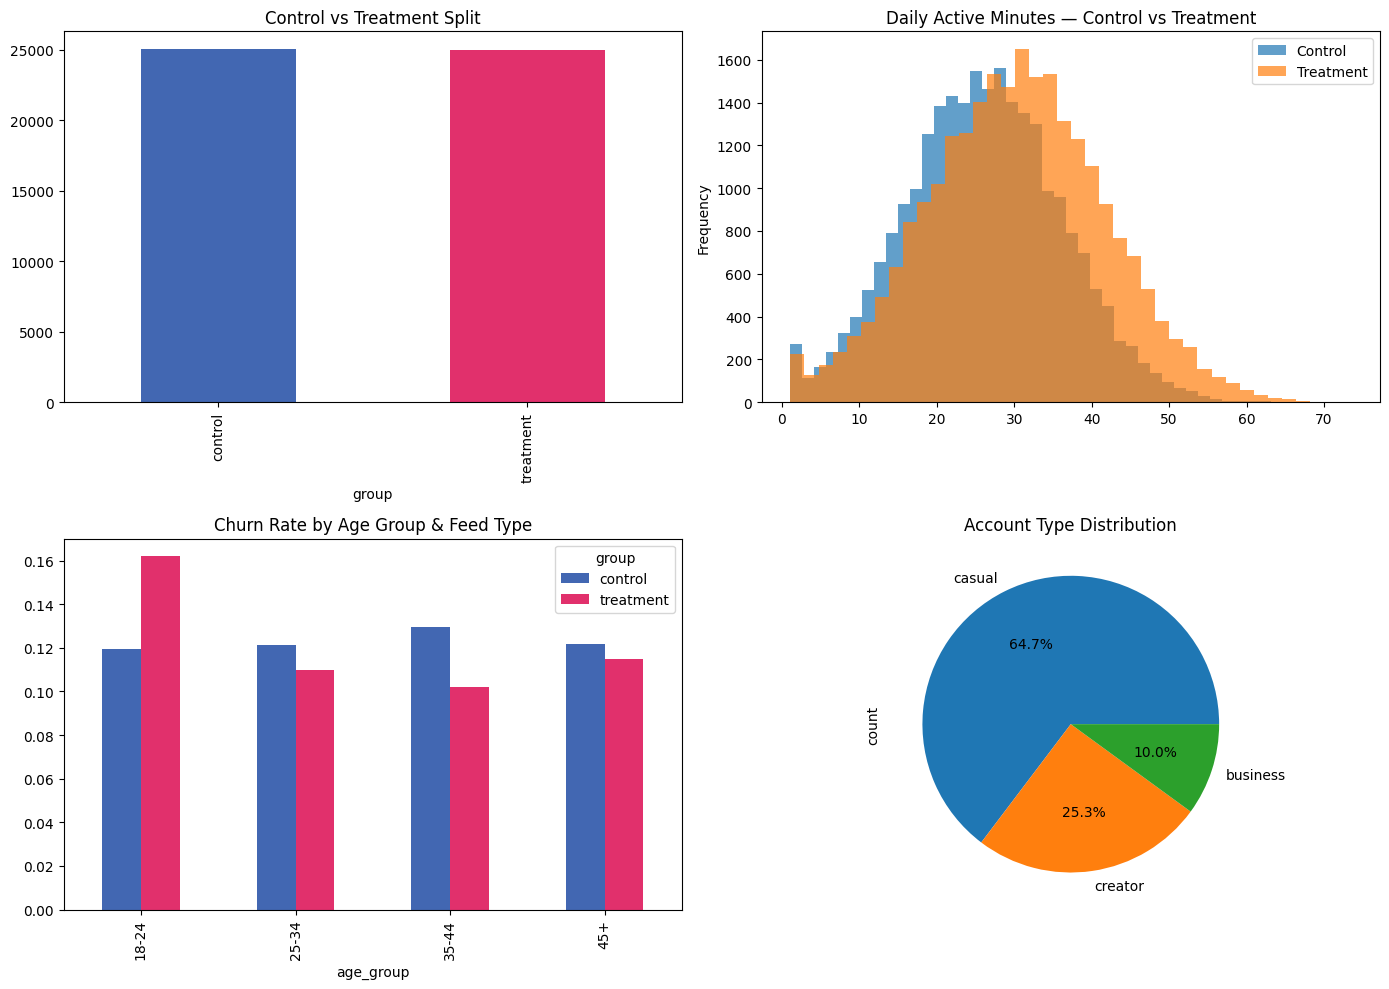

✅ Chart saved to reports/


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Group distribution (should be ~50/50)
df_clean['group'].value_counts().plot(kind='bar', ax=axes[0,0], color=['#4267B2','#E1306C'])
axes[0,0].set_title('Control vs Treatment Split')

# 2. Daily active minutes distribution by group
df_clean.groupby('group')['daily_active_minutes'].plot(kind='hist', alpha=0.7, ax=axes[0,1], bins=40)
axes[0,1].set_title('Daily Active Minutes — Control vs Treatment')
axes[0,1].legend(['Control', 'Treatment'])

# 3. Churn rate by age group
churn_by_age = df_clean.groupby(['age_group', 'group'])['churned_30d'].mean().unstack()
churn_by_age.plot(kind='bar', ax=axes[1,0], color=['#4267B2','#E1306C'])
axes[1,0].set_title('Churn Rate by Age Group & Feed Type')

# 4. Account type distribution
df_clean['account_type'].value_counts().plot(kind='pie', ax=axes[1,1], autopct='%1.1f%%')
axes[1,1].set_title('Account Type Distribution')

plt.tight_layout()
plt.savefig('../reports/data_overview.png', dpi=150, bbox_inches='tight')
plt.show()
print("✅ Chart saved to reports/")

In [9]:
git add .
git commit -m "Phase 2: data generation notebook complete — 50K user experiment dataset"
git push origin main

SyntaxError: invalid syntax (2296480858.py, line 1)